In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.svm import SVR
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import *
from random import seed
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
%matplotlib inline

seed(888)

# 1 Load data from "1. Split"

In [2]:
# load data from pickle and convert to dataframe
brain_test = pd.read_pickle("1_brain_test.pkl")
brain_train = pd.read_pickle("1_brain_train.pkl")
main_test = pd.read_pickle("1_main_test.pkl")
main_train = pd.read_pickle("1_main_train.pkl")
brain_test = pd.DataFrame(brain_test)
brain_train = pd.DataFrame(brain_train)
main_test = pd.DataFrame(main_test)
main_train = pd.DataFrame(main_train)

# 2 Accelerometer data preprocessing

- Check wear time and data quality
- Exclude people with insufficient weartime and poor data quality
- Categorize physical activity

People excluded due to wear time < 8000 minutes: 1181
Yes    8377
No        0
Name: data_quality_good_wear_time_f90015_0_0, dtype: int64
Yes    8377
No        0
Name: data_quality_good_calibration_f90016_0_0, dtype: int64


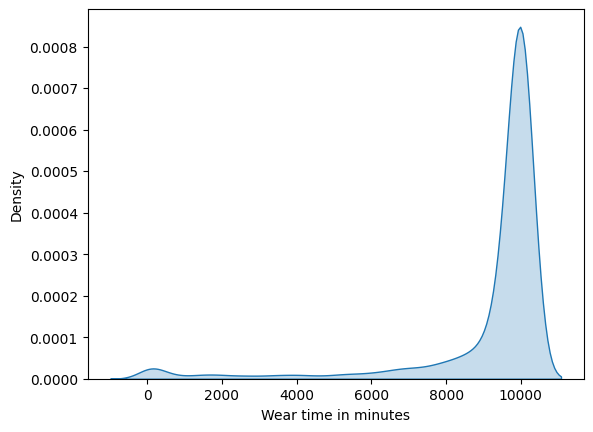

In [3]:
# get weartime duration in minutes (it's in days at default)
main_test["Wear time in minutes"] = main_test.iloc[:,16686]*1440
sns.kdeplot(data = main_test, x= 'Wear time in minutes', fill=True)

# exclude people with insufficient weartime weartime < 8000 minutes
wear_time_test = main_test[main_test["Wear time in minutes"]<8000].index
print("People excluded due to wear time < 8000 minutes:", len(wear_time_test))
brain_test = brain_test.drop(wear_time_test)
main_test = main_test.drop(wear_time_test)

# check wear time and data quality
print(main_test.iloc[:,16650].value_counts())
print(main_test.iloc[:,16651].value_counts())

In [4]:
# distributions are cumulative -> substract ditributions from each other
# determine fraction of weartime spent doing light PA (between 30 and 125 milligravites)
light_PA = np.asarray(main_test.iloc[:,16763]-main_test.iloc[:,16748])
# get it in minutes / week
light_PA = light_PA * main_test["Wear time in minutes"]
main_test["Light PA"] = light_PA

# determine fraction of weartime spent doing moderate PA (between 125 and 400 milligravites)
moderate_PA = np.asarray(main_test.iloc[:,16774]-main_test.iloc[:,16763])
moderate_PA = moderate_PA * main_test["Wear time in minutes"]
main_test["Moderate PA"] = moderate_PA

# determine fraction of weartime spent doing vigorous PA (above 400 milligravites)
vigorous_PA = np.asarray(1-main_test.iloc[:,16774])
vigorous_PA = vigorous_PA * main_test["Wear time in minutes"]
main_test["Vigorous PA"] = vigorous_PA

# fraction of weartime for above 30 mg -> total summed light, moderate, and vigorous PA
total_PA = np.asarray(1-main_test.iloc[:,16748])
total_PA = total_PA * main_test["Wear time in minutes"]
main_test["Total PA"] = total_PA

# moderate + 2* vigorous PA -> weighten greater than moderate activity
main_test["MVPA"] = main_test["Moderate PA"] + main_test["Vigorous PA"]*2

# 3 Exclusion

## 3.1 Exclusion based on brain neoplasms, nervous system disorders, or circulatory disease

Self rated long standing illness and health measured are no longer used for exclusions

Subjects are not deleted, but a column that indicates whether that subject would have been excluded (1) or not (0) is added to the main_test dataframe

In [5]:
print("Size of test set before exclusions:", main_test.shape[0])
print("Size of train set before exclusions:", main_train.shape[0])

main_train["Excluded"] = 0
main_test["Excluded"] = 0

# these self-report exclusions are no longer used
# exclude people with long standing illness diability or infirmity
# index_illness_train = main_train[main_train["longstanding_illness_disability_or_infirmity_f2188_0_0"]!= "No"].index
# index_illness_test = main_test[main_test["longstanding_illness_disability_or_infirmity_f2188_0_0"]!= "No"].index
# main_test.loc[index_illness_test,"Excluded"] = 0
# main_train.loc[index_illness_train,"Excluded"] = 0
# print("People excluded due to long standing illness (Self-report):","Train Set -", len(index_illness_train),"; Test Set - ", len(index_illness_test))

# # exclude people who don't have good or excellent self-rated health
# health_train = main_train[(main_train["overall_health_rating_f2178_0_0"]!= "Good") & (main_train["overall_health_rating_f2178_0_0"]!= "Excellent")].index
# health_test = main_test[(main_test["overall_health_rating_f2178_0_0"]!= "Good") & (main_test["overall_health_rating_f2178_0_0"]!= "Excellent")].index
# main_test.loc[health_test,"Excluded"] = 0
# main_train.loc[health_train,"Excluded"] = 0
# print("People excluded due to not good or excellent health (Self-report):","Train Set -", len(health_train),"; Test Set - ", len(health_test))

# only these exclusions
# exclude people with disorders of the nervous system
nervous_train = main_train[main_train["diagnoses_icd10_f41270_0_0"].str.contains("G")==True].index
nervous_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("G")==True].index
main_test.loc[nervous_test,"Excluded"] = 1
main_train.loc[nervous_train,"Excluded"] = 1
print("People excluded due to disorders of the nervous system (G):","Train Set -", len(nervous_train),"; Test Set - ", len(nervous_test))

# exclude people with malicious neoplasm in the brain
neoplasm_train = main_train[main_train["diagnoses_icd10_f41270_0_0"].str.contains("C71")==True].index
neoplasm_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("C71")==True].index
main_test.loc[neoplasm_test,"Excluded"] = 1
main_train.loc[neoplasm_train,"Excluded"] = 1
print("People excluded due to malicious neoplasms in the brain (C71):","Train Set -", len(neoplasm_train),"; Test Set - ", len(neoplasm_test))

# exclude people with circulatory disease 
circulatory_train = main_train[main_train["diagnoses_icd10_f41270_0_0"].str.contains("I")==True].index
circulatory_test = main_test[main_test["diagnoses_icd10_f41270_0_0"].str.contains("I")==True].index
main_test.loc[circulatory_test,"Excluded"] = 1
main_train.loc[circulatory_train,"Excluded"] = 1
print("People excluded due to circulatory disease (I):","Train Set -", len(circulatory_train),"; Test Set - ", len(circulatory_test))

print("Total number of exclusions in test set:", len(nervous_test)+len(neoplasm_test)+len(circulatory_test))
print("Total number of exclusions in train set:", len(nervous_train)+len(neoplasm_train)+len(circulatory_train))

Size of test set before exclusions: 8377
Size of train set before exclusions: 24035
People excluded due to disorders of the nervous system (G): Train Set - 744 ; Test Set -  276
People excluded due to malicious neoplasms in the brain (C71): Train Set - 7 ; Test Set -  1
People excluded due to circulatory disease (I): Train Set - 1792 ; Test Set -  622
Total number of exclusions in test set: 899
Total number of exclusions in train set: 2543


## 3.2 Exclude people with bad quality brain scan

In [6]:
before_test = main_test.shape[0]
before_train = main_train.shape[0]

good_test = main_test.iloc[:,10065].isnull()
brain_test = brain_test[good_test]
main_test = main_test[good_test]

good_train = main_train.iloc[:,10065].isnull()
brain_train = brain_train[good_train]
main_train = main_train[good_train]

after_test = main_test.shape[0]
after_train = main_train.shape[0]

print("People excluded due to poor quality brain scan:", "Train set -", before_train - after_train, "; Test set -", before_test - after_test)

People excluded due to poor quality brain scan: Train set - 41 ; Test set - 13


# 4 Select variables of interest

In [7]:
# same for full dataset without exclusions
main_test_crop = []
main_test_crop = pd.DataFrame(main_test_crop)

main_test_crop["Age"] = main_test["Age"]
main_test_crop["Gender"] = main_test.iloc[:,22]
main_test_crop["TPA"] = main_test["Total PA"]
main_test_crop["VPA"] = main_test["Vigorous PA"]
main_test_crop["MPA"] = main_test["Moderate PA"]
main_test_crop["MVPA"] = main_test["MVPA"]
main_test_crop["LPA"] = main_test["Light PA"]
main_test_crop["BMI"] = main_test.iloc[:,11580]
main_test_crop["ECGW"] = main_test.iloc[:, 5773]
main_test_crop["ECGHR"] = main_test.iloc[:, 5775]
main_test_crop["SRLPA"] = main_test.iloc[:,9989]
main_test_crop["SRMPA"] = main_test.iloc[:,9990]
main_test_crop["SRVPA"] = main_test.iloc[:,9991]
main_test_crop["FI"] = main_test.iloc[:,9052]
main_test_crop["HGL"] = main_test.iloc[:,64]
main_test_crop["HGR"] = main_test.iloc[:,68]
main_test_crop["IS"] = main_test['uk_biobank_assessment_centre_f54_2_0']
main_test_crop["Smoking"] = main_test.iloc[:,650]
main_test_crop["SES"] = main_test.iloc[:,456]
main_test_crop["HR"] = main_test.iloc[:,10079]
main_test_crop["JPA"] = main_test.iloc[:,507]
main_test_crop["DBP"] = main_test.iloc[:,1551]
main_test_crop["SBP"] = main_test.iloc[:,1559]
main_test_crop["WS"] = main_test.iloc[:,542]
main_test_crop["Excluded"] = main_test["Excluded"]

main_test = main_test_crop


# main train
main_train["Age"] = main_train["Age"]
main_train["Gender"] = main_train.iloc[:,22]
main_train["BMI"] = main_train.iloc[:,11580]
main_train["ECGW"] = main_train.iloc[:, 5773]
main_train["ECGHR"] = main_train.iloc[:, 5775]
main_train["SRLPA"] = main_train.iloc[:,9989]
main_train["SRMPA"] = main_train.iloc[:,9990]
main_train["SRVPA"] = main_train.iloc[:,9991]
main_train["FI"] = main_train.iloc[:,9052]
main_train["HGL"] = main_train.iloc[:,64]
main_train["HGR"] = main_train.iloc[:,68]
main_train["IS"] = main_train['uk_biobank_assessment_centre_f54_2_0']
main_train["Smoking"] = main_train.iloc[:,650]
main_train["SES"] = main_train.iloc[:,456]
main_train["HR"] = main_train.iloc[:,10079]
main_train["JPA"] = main_train.iloc[:,507]
main_train["DBP"] = main_train.iloc[:,1551]
main_train["SBP"] = main_train.iloc[:,1559]
main_train["WS"] = main_train.iloc[:,542]
main_train["Excluded"] = main_train["Excluded"]

# 5 Pickle for next script

In [8]:
main_test.to_pickle("2_main_test.pkl")
main_train.to_pickle("2_main_train.pkl")
brain_train.to_pickle("2_brain_train.pkl")
brain_test.to_pickle("2_brain_test.pkl")